In [1]:
import os
import sys
import numpy as np
import matplotlib
matplotlib.use('nbagg')
#from matplotlib import style
#style.use('ggplot')
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

from astropy.io import fits
from mmtwfs.wfs import *

25.1801801802 14.5495495495


<IPython.core.display.Javascript object>


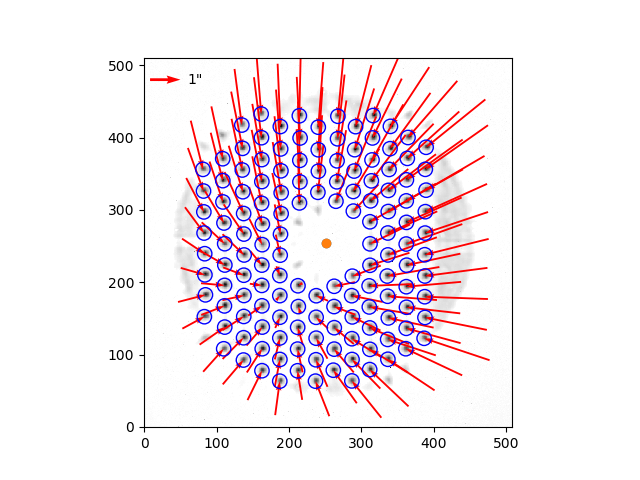

In [164]:
f9wfs = WFSFactory(wfs="f9", nzern=20, back_h=0.9)
f9_file = "/Users/tim/MMT/wfsdat/20170108/auto_wfs_0014.fits"
results = f9wfs.measure_slopes(f9_file, 'blue', plot=True)
plt.show()

Phase Amplitude Coefficients
 Z02:       117 nm 	 X Tilt (1, 1)
 Z03:       226 nm 	 Y Tilt (1, -1)
 Z04:  2.08e+03 nm 	 Defocus (2, 0)
 Z05:       348 nm 	 Primary Astig at 45˚ (2, -2)
 Z06:       455 nm 	 Primary Astig at 0˚ (2, 2)
 Z07:  1.34e+03 nm 	 Primary Y Coma (3, -1)
 Z08:  1.51e+03 nm 	 Primary X Coma (3, 1)
 Z09:       329 nm 	 Y Trefoil (3, -3)
 Z10:      -120 nm 	 X Trefoil (3, 3)
 Z11:  1.44e+03 nm 	 Primary Spherical (4, 0)
 Z12:  2.48e+03 nm 	 Secondary Astigmatism at 0˚ (4, 2)
 Z13:  1.73e+03 nm 	 Secondary Astigmatism at 45˚ (4, -2)
 Z14:       408 nm 	 X Tetrafoil (4, 4)
 Z15:       220 nm 	 Y Tetrafoil (4, -4)
 Z16:  2.58e+03 nm 	 Secondary X Coma (5, 1)
 Z17:       986 nm 	 Secondary Y Coma (5, -1)
 Z18:     -46.6 nm 	 Secondary X Trefoil (5, 3)
 Z19:       915 nm 	 Secondary Y Trefoil (5, -3)
 Z20:      -806 nm 	 X Pentafoil (5, 5)
 Z21:      -787 nm 	 Y Pentafoil (5, -5)



<IPython.core.display.Javascript object>


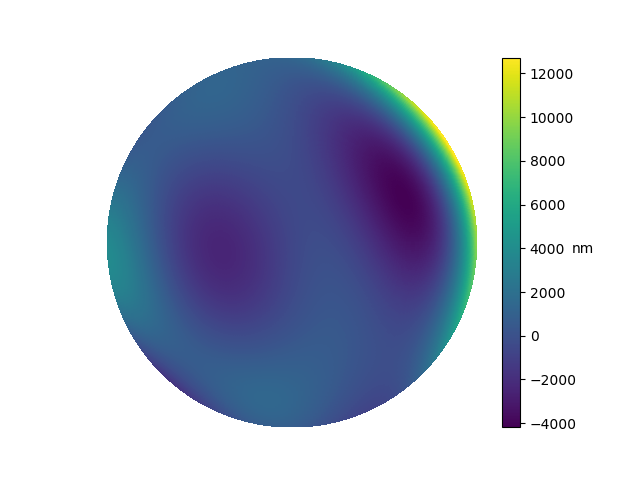

In [165]:
zv = f9wfs.fit_wavefront(results)
print(zv)
zv.ignore('Z02')
zv.ignore('Z03')
zv.plot_map()
plt.show()

29.2792792793 29.0990990991


<IPython.core.display.Javascript object>


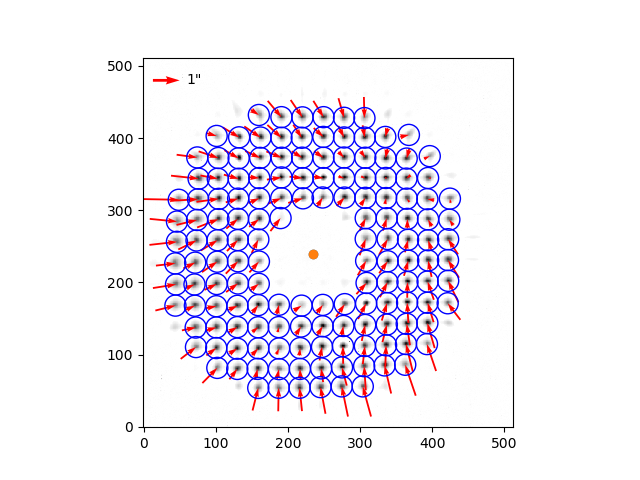

In [170]:
f5wfs = WFSFactory(wfs="f5", nzern=20, back_h=0.9)
f5_file = "/Users/tim/MMT/wfsdat/20170301/auto_wfs_0001.fits"
results = f5wfs.measure_slopes(f5_file, 'hecto', plot=True)
plt.show()

Phase Amplitude Coefficients
 Z02:        39 nm 	 X Tilt (1, 1)
 Z03:     -9.08 nm 	 Y Tilt (1, -1)
 Z04:      67.9 nm 	 Defocus (2, 0)
 Z05:      27.9 nm 	 Primary Astig at 45˚ (2, -2)
 Z06:       123 nm 	 Primary Astig at 0˚ (2, 2)
 Z07:     -80.3 nm 	 Primary Y Coma (3, -1)
 Z08:       323 nm 	 Primary X Coma (3, 1)
 Z09:      83.4 nm 	 Y Trefoil (3, -3)
 Z10:      50.3 nm 	 X Trefoil (3, 3)
 Z11:      52.8 nm 	 Primary Spherical (4, 0)
 Z12:       552 nm 	 Secondary Astigmatism at 0˚ (4, 2)
 Z13:       125 nm 	 Secondary Astigmatism at 45˚ (4, -2)
 Z14:      27.2 nm 	 X Tetrafoil (4, 4)
 Z15:     -6.52 nm 	 Y Tetrafoil (4, -4)
 Z16:       382 nm 	 Secondary X Coma (5, 1)
 Z17:     -44.5 nm 	 Secondary Y Coma (5, -1)
 Z18:       236 nm 	 Secondary X Trefoil (5, 3)
 Z19:       423 nm 	 Secondary Y Trefoil (5, -3)
 Z20:     -65.7 nm 	 X Pentafoil (5, 5)
 Z21:      33.5 nm 	 Y Pentafoil (5, -5)

236.06129994861948 nm


<IPython.core.display.Javascript object>


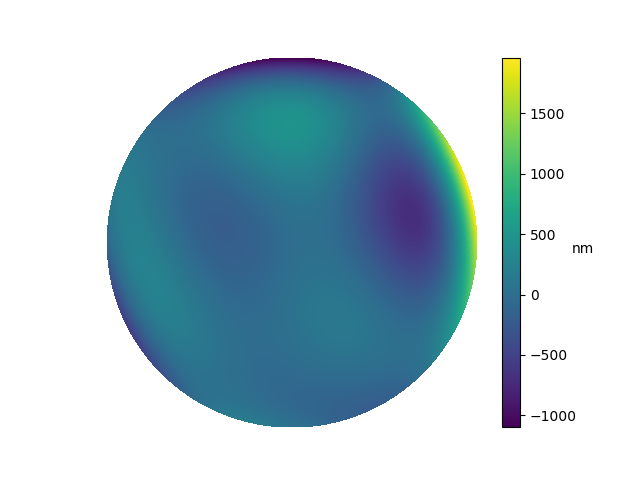

In [171]:
zv = f5wfs.fit_wavefront(results)
print(zv)
zv.ignore('Z02')
zv.ignore('Z03')
print(zv.rms)
zv.plot_map()
plt.show()

22.0720720721 22.1171171171


<IPython.core.display.Javascript object>


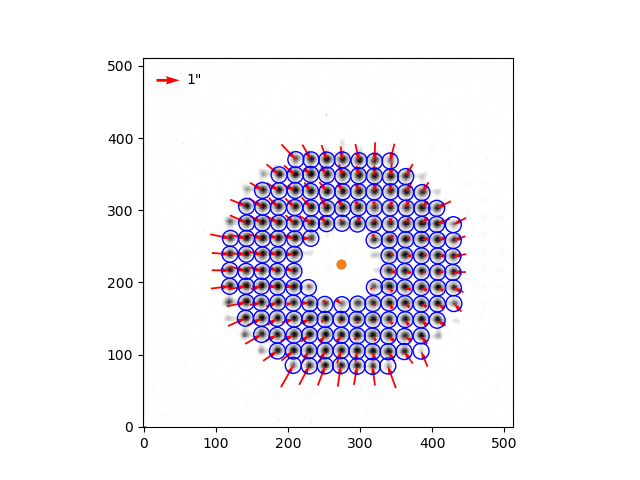

In [166]:
mmirs = WFSFactory(wfs="mmirs", nzern=20, back_h=0.9)
mmirs_file = "/Users/tim/MMT/wfsdat/20170110/rawdata/mmirs_wfs_0073.fits"
results = mmirs.measure_slopes(mmirs_file, 'mmirs2', plot=True)
plt.show()

Phase Amplitude Coefficients
 Z02:      22.5 nm 	 X Tilt (1, 1)
 Z03:     -11.3 nm 	 Y Tilt (1, -1)
 Z04:       239 nm 	 Defocus (2, 0)
 Z05:      31.7 nm 	 Primary Astig at 45˚ (2, -2)
 Z06:        45 nm 	 Primary Astig at 0˚ (2, 2)
 Z07:       -92 nm 	 Primary Y Coma (3, -1)
 Z08:       229 nm 	 Primary X Coma (3, 1)
 Z09:      43.1 nm 	 Y Trefoil (3, -3)
 Z10:     -3.88 nm 	 X Trefoil (3, 3)
 Z11:       197 nm 	 Primary Spherical (4, 0)
 Z12:       216 nm 	 Secondary Astigmatism at 0˚ (4, 2)
 Z13:       145 nm 	 Secondary Astigmatism at 45˚ (4, -2)
 Z14:     -16.5 nm 	 X Tetrafoil (4, 4)
 Z15:     -11.1 nm 	 Y Tetrafoil (4, -4)
 Z16:       256 nm 	 Secondary X Coma (5, 1)
 Z17:      -151 nm 	 Secondary Y Coma (5, -1)
 Z18:        39 nm 	 Secondary X Trefoil (5, 3)
 Z19:       199 nm 	 Secondary Y Trefoil (5, -3)
 Z20:     -33.2 nm 	 X Pentafoil (5, 5)
 Z21:     -11.9 nm 	 Y Pentafoil (5, -5)

188.17129956688902 nm


<IPython.core.display.Javascript object>


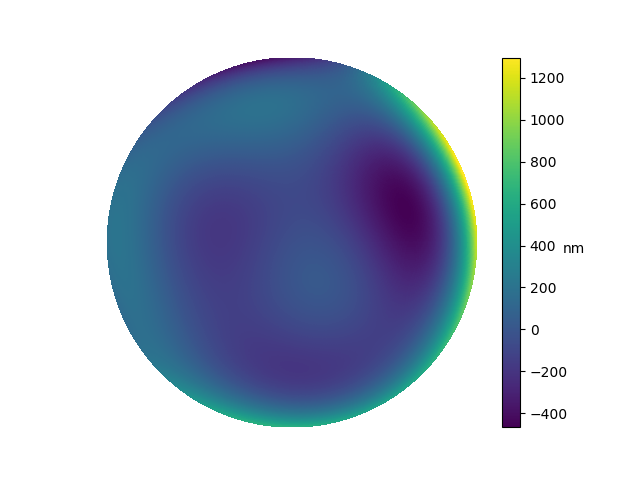

In [167]:
zv = mmirs.fit_wavefront(results)
print(zv)
zv.ignore('Z02')
zv.ignore('Z03')
print(zv.rms)
zv.plot_map()
plt.show()

In [ ]:
pup = f5wfs.pupil_mask(rotator=0)
plt.imshow(pup)
plt.show()

In [ ]:
im = check_wfsdata(f5_file)
back = background(im, h=0.9)
plt.imshow(im-back, origin='lower')
plt.show()

In [ ]:
subt = im - back
fits.writeto("blah.fits", subt, overwrite=True)

In [ ]:
cen = center_pupil(subt, pup, plot=True)
print(cen)
plt.show()

In [ ]:
mmirs.modes['mmirs2']['reference']['xspacing']

In [ ]:
results['xcen'], results['ycen']

In [ ]:
f5wfs.modes['hecto']['reference']

In [ ]:
f9wfs.tiltfactor

In [122]:
mmirs.modes['mmirs2']['reference']

{'apertures': <Table length=153>
   id    xcentroid      ycentroid    ...      mag            dist    
 int64    float64        float64     ...    float64        float64   
 ----- -------------- -------------- ... -------------- -------------
     6  43.8252254356 -147.344109706 ... -3.49109714506 153.723573499
     7  66.6704616338 -147.645104009 ... -3.52983061677 162.000083927
    11 -69.9313906955 -146.722322221 ... -3.41652046123 162.535655296
    12 -47.1023075238 -146.668048028 ... -3.47393854409 154.045914215
    13 -24.3098327699  -146.70309325 ... -3.50881211547 148.703616426
    14 -1.57217193317 -146.852915539 ... -3.59622961958 146.861330945
    15  21.1697042352 -147.006608762 ... -3.45511333459 148.523060153
    16  112.313536431 -125.274794869 ... -3.47651722338 168.250125394
    19  43.9379738877 -124.194073785 ...  -3.4566034511 131.737289758
    20  66.6983250003 -124.501429663 ... -3.53285665373 141.241893736
   ...            ...            ... ...            ...  

In [135]:
f5wfs.modes['hecto']['reference']

{'apertures': <Table length=149>
   id    xcentroid      ycentroid    ...      mag            dist    
 int64    float64        float64     ...    float64        float64   
 ----- -------------- -------------- ... -------------- -------------
    53 -76.7162820192  -192.27840505 ...   -3.009883846 207.017808353
    54 -46.9992669895 -192.336001281 ... -2.99037056092  197.99512238
    55 -17.2226485992 -192.335587977 ... -2.95901919712 193.105147594
    56  12.4704123059 -192.328092448 ... -2.94848457817 192.731954609
    57  42.2163974956 -192.292475997 ... -3.08068662172 196.872091832
    58  71.9106332095 -192.263976038 ... -3.05870867225 205.271955343
    70 -135.994498814 -162.494091699 ... -3.09914127069 211.893448565
    71 -106.417572446 -162.597412392 ... -3.00310525107 194.326061664
    72 -76.7585682183 -162.658830746 ... -2.99516997376 179.860426483
    73 -47.0371619871 -162.651612767 ... -2.93572397527 169.316395377
   ...            ...            ... ...            ...  